# Music Genre Classification - MLDL - A.Y. 2020/21 - Politecnico di Torino

In [1]:
import torchvision
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import time
from datetime import timedelta
from datetime import datetime


# 1. Preparing the Dataset, Utility Functions, and Pre-Processing

---





## 1.1. Mounting the Dataset Folder

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


## 1.2. Defining Transform Classes
The first transform (CustomToTensor) only transforms images into grayscale. The second one (CustomToTensorAndNormalized) also normalizes the dataset (into [0, 1] interval) by dividing the image tensors by 255.

In [3]:
class CustomToTensor(object):
    """Convert PIL Images in sample to pytorch Tensors."""
    ## the input image must be grayscaled first
    def __call__(self, image):
        image = np.array(image, dtype=np.float32)
        # numpy image: H x W
        return torch.from_numpy(image)
class CustomToTensorAndNormalized(object):
    def __call__(self, image):
        image = np.array(image, dtype=np.float32) / 255 # Normalized
        return torch.from_numpy(image)

## 1.3. Train-Test Split and Number Distribution
The following function receives the dataset, batch_size, and validation_split percentage (e.g. 0.2) and returns train and test loaders. Train-test split is done using sklearn's train_test_split with stratification. (Each class will be divided equally.)

In [4]:
def sktrain_test_split(dataset, batch_size, validation_split):
  targets = dataset.targets
  targets.sort()
  train_indices, test_indices = train_test_split(np.arange(len(targets)), test_size= validation_split, random_state=52, shuffle=True, stratify=targets)
  # Creating PT data samplers and loaders:
  train_sampler = SubsetRandomSampler(train_indices)
  test_sampler = SubsetRandomSampler(test_indices)

  train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=16)
  test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, num_workers=16)
  return train_loader, test_loader

The following block creates our datasets (one normalized and one not normalized). The, classes are extracted and printed. Afterwards, train_test_split for different settings (not normalized, and normalized with different batch sizes) is done.

In [5]:
transform = transforms.Compose([transforms.Grayscale(), CustomToTensor()])
transform_norm = transforms.Compose([transforms.Grayscale(), CustomToTensorAndNormalized()]) 
dataset = ImageFolder("/content/drive/My Drive/categorized_products", transform=transform)
dataset_norm = ImageFolder("/content/drive/My Drive/categorized_products", transform=transform_norm)
classes = dataset.classes
print(classes)
print(len(classes))
train_loader, test_loader = sktrain_test_split(dataset, 64, 0.2)
train_loader_norm64, test_loader_norm64 = sktrain_test_split(dataset_norm, 64, 0.2)
train_loader_norm32, test_loader_norm32 = sktrain_test_split(dataset_norm, 32, 0.2)
train_loader_norm128, test_loader_norm128 = sktrain_test_split(dataset_norm, 128, 0.2)

['Accessory Gift Set', 'Backpacks', 'Belts', 'Capris', 'Caps', 'Casual Shoes', 'Clutches', 'Cufflinks', 'Deodorant', 'Dresses', 'Dupatta', 'Earrings', 'Flats', 'Flip Flops', 'Formal Shoes', 'Handbags', 'Heels', 'Innerwear Vests', 'Jackets', 'Jeans', 'Kajal and Eyeliner', 'Kurtas', 'Kurtis', 'Leggings', 'Lip Gloss', 'Lipstick', 'Nail Polish', 'Necklace and Chains', 'Night suits', 'Nightdress', 'Pendant', 'Perfume and Body Mist', 'Ring', 'Sandals', 'Sarees', 'Scarves', 'Shirts', 'Shorts', 'Skirts', 'Socks', 'Sports Shoes', 'Sunglasses', 'Sweaters', 'Sweatshirts', 'Ties', 'Tops', 'Track Pants', 'Trousers', 'Tshirts', 'Tunics', 'Wallets', 'Watches']
52


The following function receives a data loader (test or train) and prints and returns the number of images in each category.

In [6]:
def get_number_distribution(loader, classes):
  total_category_count = {classes[i] : 0 for i in range(len(classes))}
  for _, labels in loader:
    for label in labels:
      total_category_count[ classes[label] ] += 1
  cat_count = []
  for category in classes:
    print('%s : %d' % (category, total_category_count[category]))
    cat_count.append((category, total_category_count[category]))
  cat_count.sort(key=lambda x:x[1])
  cat_count.reverse()
  return cat_count

In the following blocks, the number distributions of train and test datasets are printed. Also, the split percentage of each class is printed to validate if all classes are equally splitted (e.g. to 20/80).

In [7]:
print('Train Set Number Ditribution:')
train_cat_count = get_number_distribution(train_loader, classes)

Train Set Number Ditribution:
Accessory Gift Set : 89
Backpacks : 578
Belts : 650
Capris : 140
Caps : 226
Casual Shoes : 2277
Clutches : 232
Cufflinks : 85
Deodorant : 278
Dresses : 371
Dupatta : 93
Earrings : 334
Flats : 400
Flip Flops : 733
Formal Shoes : 510
Handbags : 1406
Heels : 1058
Innerwear Vests : 193
Jackets : 206
Jeans : 486
Kajal and Eyeliner : 82
Kurtas : 1475
Kurtis : 187
Leggings : 142
Lip Gloss : 115
Lipstick : 252
Nail Polish : 263
Necklace and Chains : 128
Night suits : 113
Nightdress : 151
Pendant : 140
Perfume and Body Mist : 490
Ring : 94
Sandals : 718
Sarees : 339
Scarves : 94
Shirts : 2570
Shorts : 438
Skirts : 102
Socks : 549
Sports Shoes : 1628
Sunglasses : 858
Sweaters : 222
Sweatshirts : 228
Ties : 209
Tops : 1409
Track Pants : 242
Trousers : 424
Tshirts : 2827
Tunics : 183
Wallets : 749
Watches : 2033


In [8]:
print('Test Set Number Ditribution:')
test_cat_count = get_number_distribution(test_loader, classes)

Test Set Number Ditribution:
Accessory Gift Set : 22
Backpacks : 144
Belts : 163
Capris : 35
Caps : 57
Casual Shoes : 569
Clutches : 58
Cufflinks : 21
Deodorant : 69
Dresses : 93
Dupatta : 23
Earrings : 83
Flats : 100
Flip Flops : 183
Formal Shoes : 127
Handbags : 351
Heels : 265
Innerwear Vests : 48
Jackets : 52
Jeans : 122
Kajal and Eyeliner : 20
Kurtas : 369
Kurtis : 47
Leggings : 35
Lip Gloss : 29
Lipstick : 63
Nail Polish : 66
Necklace and Chains : 32
Night suits : 28
Nightdress : 38
Pendant : 35
Perfume and Body Mist : 123
Ring : 24
Sandals : 179
Sarees : 85
Scarves : 23
Shirts : 643
Shorts : 109
Skirts : 26
Socks : 137
Sports Shoes : 407
Sunglasses : 215
Sweaters : 55
Sweatshirts : 57
Ties : 52
Tops : 353
Track Pants : 61
Trousers : 106
Tshirts : 707
Tunics : 46
Wallets : 187
Watches : 508


In [9]:
for i in range(len(train_cat_count)):
    print("Train Split Percentage of", train_cat_count[i][0], ":", train_cat_count[i][1]/(train_cat_count[i][1]+test_cat_count[i][1]))

Train Split Percentage of Tshirts : 0.7999434069043577
Train Split Percentage of Shirts : 0.7998755057578587
Train Split Percentage of Casual Shoes : 0.8000702740688685
Train Split Percentage of Watches : 0.8000787091696182
Train Split Percentage of Sports Shoes : 0.8
Train Split Percentage of Kurtas : 0.7998915401301518
Train Split Percentage of Tops : 0.7996594778660613
Train Split Percentage of Handbags : 0.8002276607854297
Train Split Percentage of Heels : 0.799697656840514
Train Split Percentage of Sunglasses : 0.7996272134203168
Train Split Percentage of Wallets : 0.8002136752136753
Train Split Percentage of Flip Flops : 0.8002183406113537
Train Split Percentage of Sandals : 0.8004459308807135
Train Split Percentage of Belts : 0.7995079950799509
Train Split Percentage of Backpacks : 0.8005540166204986
Train Split Percentage of Socks : 0.8002915451895044
Train Split Percentage of Formal Shoes : 0.8006279434850864
Train Split Percentage of Perfume and Body Mist : 0.799347471451876


## 1.4. Dataset Visualization
A bar chart representing number distribution of classes is plotted. Also, from 12 distinct classes, a picture is selected and shown.

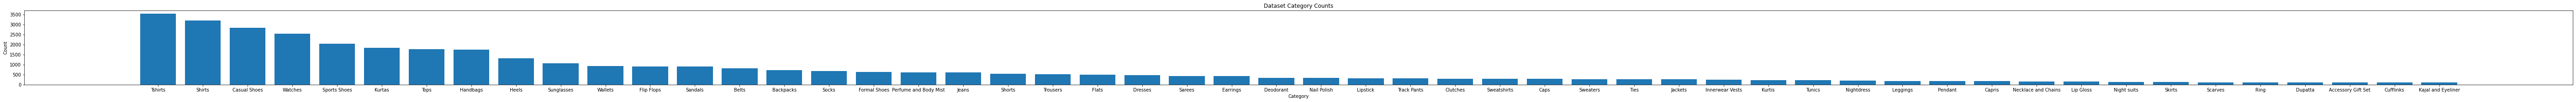

In [10]:
import matplotlib
from google.colab import files
plt.figure(figsize=(100, 3))
matplotlib.pyplot.bar([(train_cat_count[i][0]) for i in range(len(train_cat_count))], [(train_cat_count[i][1] + test_cat_count[i][1]) for i in range(len(train_cat_count))],\
                      width=0.8, bottom=None, align='center', data=None)
plt.title('Dataset Category Counts')
plt.ylabel('Count')
plt.xlabel('Category')
plt.savefig('cat_count.png', dpi=300, bbox_inches='tight')
#files.download('cat_count.png')

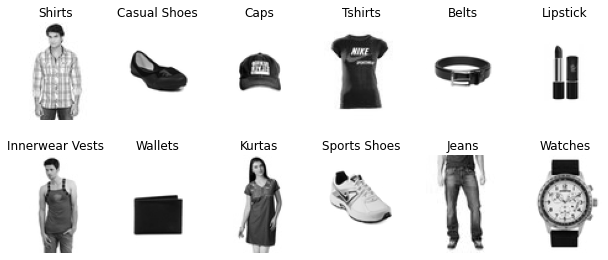

In [11]:
def imshow(img_array, labels, classes):
    figure, axs = plt.subplots(2, 6) 
    for i in range(2):
      for j in range(6):
        axs[i][j].imshow(img_array[i*6 + j], cmap='gray')
        axs[i][j].set_title(classes[labels[i*6 + j]])
        axs[i][j].axis('off')
    plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=1.5, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)
    plt.show()

data_iter = iter(train_loader)
data_iter.next()
images, labels = data_iter.next()
distinct_labels = []
distinct_images = []
distinct_classes = []
for i in range(len(labels)):
  if classes[labels[i]] not in distinct_classes:
    distinct_labels.append(labels[i])
    distinct_images.append(images[i])
    distinct_classes.append(classes[labels[i]])
imshow(distinct_images[0:12], distinct_labels[0:12], classes)

# 2. the Model

## 2.1. Defining the Model Class
The neural network is implemented using the PyTorch framework. The Model class inherits from PyTorch's nn.Module.
Relu is used as the default activation function.

In [12]:
class Model(nn.Module):
    def __init__(self, class_num, act=F.relu):
        super(Model, self).__init__()


        self.layer1 = nn.Linear(1 * 80 * 60, 1600)
        self.act1 = act


        self.layer2 = nn.Linear(1600, 800) 
        self.act2 = act


        self.layer3 = nn.Linear(800, 400)
        self.act3 = act


        self.layer4 = nn.Linear(400, 200)
        self.act4 = act

        self.layer5 = nn.Linear(200, class_num)
    def init_weights(self, constant_weight):
      #initialize weight of Linear layers as constant_weight
      nn.init.constant_(self.layer1.weight, constant_weight)
      self.layer1.bias.data.fill_(0)
      nn.init.constant_(self.layer2.weight, constant_weight)
      self.layer2.bias.data.fill_(0)
      nn.init.constant_(self.layer3.weight, constant_weight)
      self.layer3.bias.data.fill_(0)
      nn.init.constant_(self.layer4.weight, constant_weight)
      self.layer4.bias.data.fill_(0)
      nn.init.constant_(self.layer5.weight, constant_weight)
      self.layer5.bias.data.fill_(0)
    def forward(self, x):

        x = x.view(x.size(0), -1)

        x = self.layer1(x)
        x = self.act1(x)

        x = self.layer2(x)
        x = self.act2(x)

        x = self.layer3(x)
        x = self.act3(x)

        x = self.layer4(x)
        x = self.act4(x)

        x = self.layer5(x)
        return x

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [14]:
def fit(model, train_loader, device, criterion, optimizer, num_epochs=10):

  total_time = 0.
  avgLosses = []
  epochs = []
  for epoch in range(num_epochs):
      train_loss = 0.
      d1 = datetime.now()
      for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        #assert not np.any(np.isnan(loss))
        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
        train_loss += loss.item()
      average_loss = train_loss / len(train_loader)
      avgLosses.append(average_loss)
      epochs.append(epoch+1)
      d2 = datetime.now()
      delta = d2 - d1
      seconds = float(delta.total_seconds())
      total_time += seconds
      print('epoch %d, train_loss: %.3f, time elapsed: %s seconds' % (epoch + 1, average_loss, seconds))
  print('total training time: %.3f minutes' % (total_time / 60))
  return epochs, avgLosses

In [15]:
def model_accuracy(model, loader):
    # Calculate Accuracy         
    correct = 0.
    total = 0.
    # Iterate through test dataset
    class_corrects = [0.] * 52
    class_totals = [0.] * 52
    class_accs = [0.] * 52
    with torch.no_grad():
      for images, labels in loader:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to('cpu') == labels).sum().item()
        Bool = (predicted.to('cpu') == labels)
        for i in range(len(images)):
            class_totals[labels[i]] += 1
            if Bool[i] == True:
              class_corrects[labels[i]] += 1
    for i in range(52):
      class_accs[i] = class_corrects[i]/class_totals[i]
    accuracy = 100 * correct / total
    return accuracy, class_accs

In [16]:
def plotLoss(epochs, avgLosses):
  plt.figure(figsize=(20,10))
  plt.plot(epochs, avgLosses, label='Loss')
  plt.title('Loss per Epoch')
  plt.ylabel('Epoch')
  plt.xlabel('Loss')
  plt.legend()
  plt.show()
  return

In [17]:
def plotAccs(train_class_accs, test_class_accs, classesLabels):
  labels = classesLabels
  x = np.arange(len(labels))
  width = 0.2
  f = plt.figure(figsize=(100, 3))
  ax = f.subplots()
  trains = ax.bar(x - width/2, train_class_accs, width, label='Train')
  tests = ax.bar(x + width/2, test_class_accs, width, label = 'Test')
  ax.set_ylabel('Accuracy')
  ax.set_title('Accuracy of Classes for Test and Train Sets')
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()

Results of Non-Normalized 64-batch-size Dataset with Default Learning Rate and No Momentum and Regularization: (10 epochs)
epoch 1, train_loss: nan, time elapsed: 42.780672 seconds
epoch 2, train_loss: nan, time elapsed: 42.611888 seconds
epoch 3, train_loss: nan, time elapsed: 43.036033 seconds
epoch 4, train_loss: nan, time elapsed: 42.381702 seconds
epoch 5, train_loss: nan, time elapsed: 42.532168 seconds
epoch 6, train_loss: nan, time elapsed: 42.480525 seconds
epoch 7, train_loss: nan, time elapsed: 43.110767 seconds
epoch 8, train_loss: nan, time elapsed: 42.229036 seconds
epoch 9, train_loss: nan, time elapsed: 43.092112 seconds
epoch 10, train_loss: nan, time elapsed: 43.918142 seconds
total training time: 7.136 minutes
Train Set Accuracy: 0.29866774052820566%
Test Set Accuracy: 0.2953020134228188%


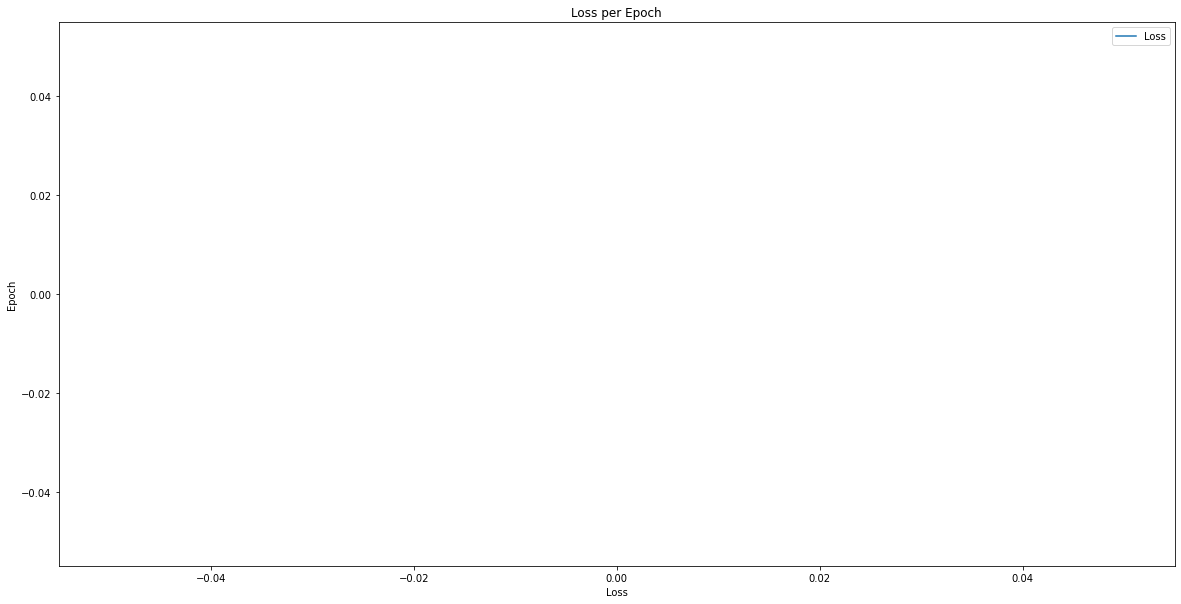

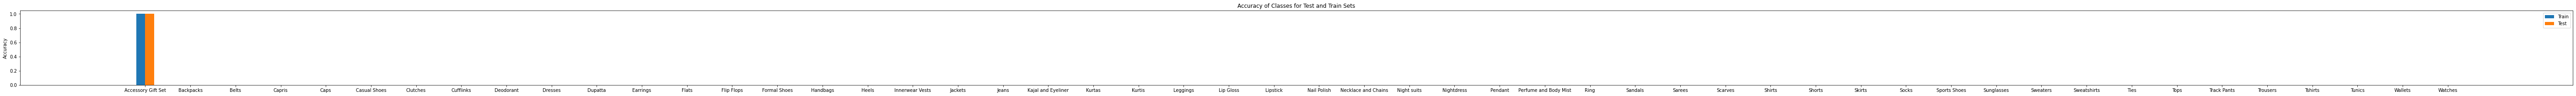

In [18]:
# Non-Normalized 64-batch-size Dataset with Random Initial Weights, Default Learning Rate, and No Momentum and Regularization (10 epochs)
model = Model(len(classes))
model = model.to(device)
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
print('Results of Non-Normalized 64-batch-size Dataset with Default Learning Rate and No Momentum and Regularization: (10 epochs)')
epochs, avgLosses = fit(model, train_loader, device, criterion, optimizer)
train_acc, train_class_accs = model_accuracy(model, train_loader)
test_acc, test_class_accs = model_accuracy(model, test_loader)
print('Train Set Accuracy: {}%'.format(train_acc))
print('Test Set Accuracy: {}%'.format(test_acc))
plotLoss(epochs, avgLosses)
plotAccs(train_class_accs, test_class_accs, classes)

Results of Normalized 64-batch-size Dataset with Default Learning Rate and No Momentum and Regularization: (10 epochs)
epoch 1, train_loss: 3.543, time elapsed: 43.041196 seconds
epoch 2, train_loss: 2.979, time elapsed: 42.99766 seconds
epoch 3, train_loss: 2.592, time elapsed: 43.527395 seconds
epoch 4, train_loss: 2.253, time elapsed: 43.175466 seconds
epoch 5, train_loss: 1.961, time elapsed: 43.718863 seconds
epoch 6, train_loss: 1.782, time elapsed: 44.577585 seconds
epoch 7, train_loss: 1.676, time elapsed: 42.728425 seconds
epoch 8, train_loss: 1.603, time elapsed: 43.289695 seconds
epoch 9, train_loss: 1.525, time elapsed: 43.913899 seconds
epoch 10, train_loss: 1.493, time elapsed: 43.122628 seconds
total training time: 7.235 minutes
Train Set Accuracy: 51.99838920769153%
Test Set Accuracy: 51.57046979865772%


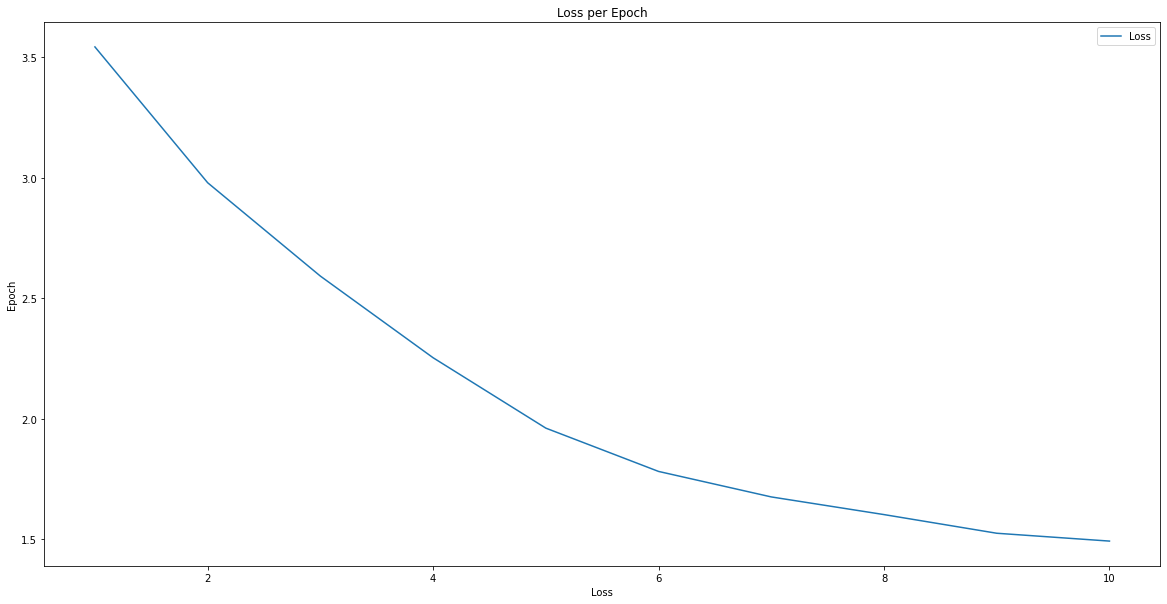

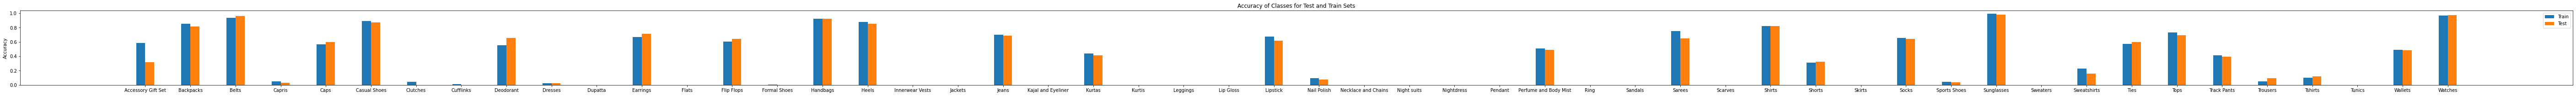

In [19]:
# Normalized 64-batch-size Dataset with Random Initial Weights, Default Learning Rate, and No Momentum and Regularization (10 epochs)
model = Model(len(classes))
model = model.to(device)
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
print('Results of Normalized 64-batch-size Dataset with Default Learning Rate and No Momentum and Regularization: (10 epochs)')
epochs, avgLosses = fit(model, train_loader_norm64, device, criterion, optimizer)
train_acc, train_class_accs = model_accuracy(model, train_loader_norm64)
test_acc, test_class_accs = model_accuracy(model, test_loader_norm64)
print('Train Set Accuracy: {}%'.format(train_acc))
print('Test Set Accuracy: {}%'.format(test_acc))
plotLoss(epochs, avgLosses)
plotAccs(train_class_accs, test_class_accs, classes)

Results of Normalized 64-batch-size Dataset with Default Learning Rate and No Momentum and Regularization: (10 epochs)
epoch 1, train_loss: 3.896, time elapsed: 43.440678 seconds
epoch 2, train_loss: 3.798, time elapsed: 43.900693 seconds
epoch 3, train_loss: 3.720, time elapsed: 43.475189 seconds
epoch 4, train_loss: 3.661, time elapsed: 42.905169 seconds
epoch 5, train_loss: 3.616, time elapsed: 43.143572 seconds
epoch 6, train_loss: 3.582, time elapsed: 43.663235 seconds
epoch 7, train_loss: 3.557, time elapsed: 42.43155 seconds
epoch 8, train_loss: 3.538, time elapsed: 42.845897 seconds
epoch 9, train_loss: 3.524, time elapsed: 44.224911 seconds
epoch 10, train_loss: 3.512, time elapsed: 42.707184 seconds
total training time: 7.212 minutes
Train Set Accuracy: 9.48689553340716%
Test Set Accuracy: 9.48993288590604%


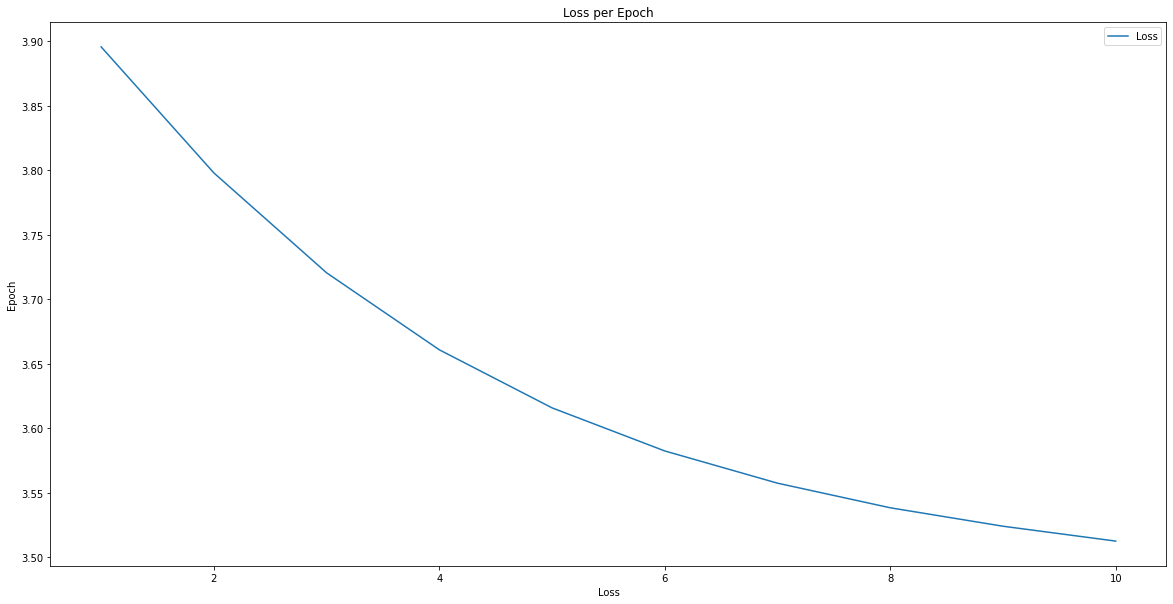

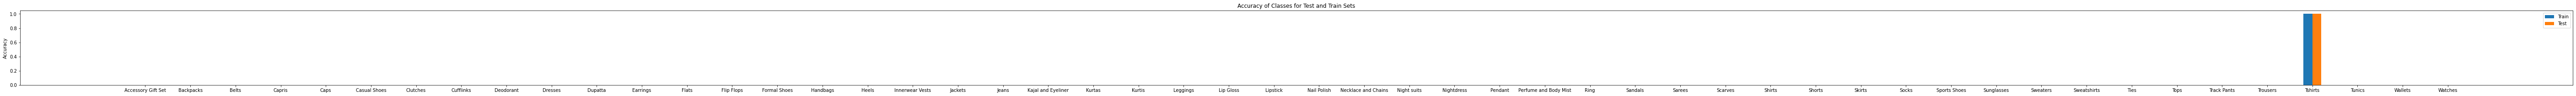

In [20]:
# Normalized 64-batch-size Dataset with Zero Initial Weights, Default Learning Rate, and No Momentum and Regularization (10 epochs)
model = Model(len(classes))
model = model.to(device)
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
model.init_weights(0)
print('Results of Normalized 64-batch-size Dataset with Default Learning Rate and No Momentum and Regularization: (10 epochs)')
epochs, avgLosses = fit(model, train_loader_norm64, device, criterion, optimizer)
train_acc, train_class_accs = model_accuracy(model, train_loader_norm64)
test_acc, test_class_accs = model_accuracy(model, test_loader_norm64)
print('Train Set Accuracy: {}%'.format(train_acc))
print('Test Set Accuracy: {}%'.format(test_acc))
plotLoss(epochs, avgLosses)
plotAccs(train_class_accs, test_class_accs, classes)

Results of Normalized 64-batch-size Dataset with Learning Rate = 0.001  and No Momentum and Regularization: (10 epochs)
epoch 1, train_loss: 3.932, time elapsed: 43.884477 seconds
epoch 2, train_loss: 3.884, time elapsed: 44.361788 seconds
epoch 3, train_loss: 3.737, time elapsed: 44.097747 seconds
epoch 4, train_loss: 3.507, time elapsed: 43.984013 seconds
epoch 5, train_loss: 3.458, time elapsed: 43.780501 seconds
epoch 6, train_loss: 3.440, time elapsed: 44.156182 seconds
epoch 7, train_loss: 3.425, time elapsed: 44.466583 seconds
epoch 8, train_loss: 3.405, time elapsed: 43.332753 seconds
epoch 9, train_loss: 3.370, time elapsed: 44.704951 seconds
epoch 10, train_loss: 3.304, time elapsed: 44.028301 seconds
total training time: 7.347 minutes
Train Set Accuracy: 16.329407027081444%
Test Set Accuracy: 16.36241610738255%
Results of Normalized 64-batch-size Dataset with Learning Rate = 0.003  and No Momentum and Regularization: (10 epochs)
epoch 1, train_loss: 3.759, time elapsed: 43.8

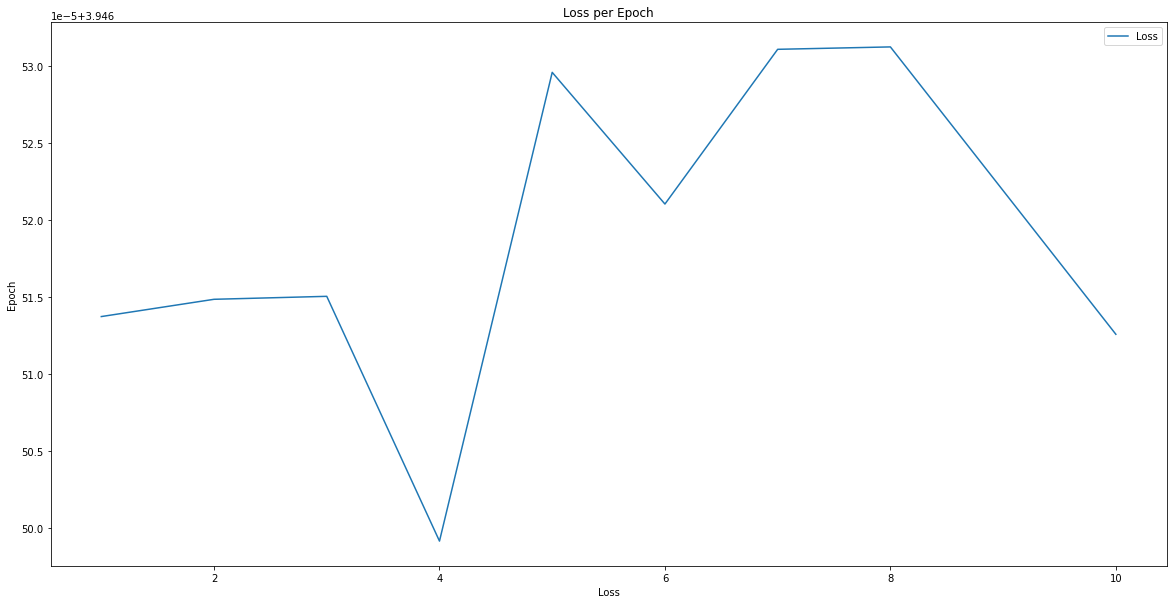

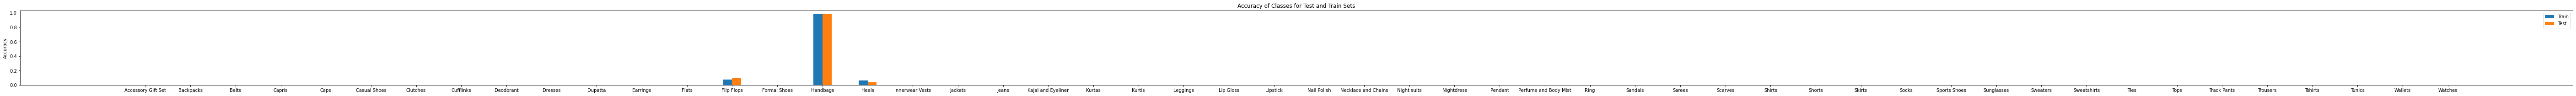

In [22]:
# Optimizing Learning Rate for Normalized 64-batch-size Dataset with Random Initial Weights, and No Momentum and Regularization (10 epochs)
maxAcc = -1
bestLr = -1
LRs = [0.001, 0.003, 0.006, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
for LR in LRs:
  model = Model(len(classes))
  model = model.to(device)
  print('Results of Normalized 64-batch-size Dataset with Learning Rate =', LR, ' and No Momentum and Regularization: (10 epochs)')
  optimizer = torch.optim.SGD(model.parameters(), lr=LR)
  criterion = nn.CrossEntropyLoss()
  epochs, avgLosses = fit(model, train_loader_norm64, device, criterion, optimizer)
  train_acc, train_class_accs = model_accuracy(model, train_loader_norm64)
  test_acc, test_class_accs = model_accuracy(model, test_loader_norm64)
  print('Train Set Accuracy: {}%'.format(train_acc))
  print('Test Set Accuracy: {}%'.format(test_acc))
  if test_acc > maxAcc:
    maxAcc = test_acc
    bestLR = LR
print('Optimum Learning Rate is:', bestLR, 'With Accuracy of', maxAcc)
print('Results of Normalized 64-batch-size Dataset with Optimum Learning Rate and No Momentum and Regularization: (10 epochs)')
model = Model(len(classes))
model = model.to(device)
epochs, avgLosses = fit(model, train_loader_norm64, device, criterion, optimizer)
train_acc, train_class_accs = model_accuracy(model, train_loader_norm64)
test_acc, test_class_accs = model_accuracy(model, test_loader_norm64)
plotLoss(epochs, avgLosses)
plotAccs(train_class_accs, test_class_accs, classes)

Results of Normalized 32-batch-size Dataset with Optimum Learning Rate and No Momentum and Regularization: (10 epochs)
epoch 1, train_loss: 2.702, time elapsed: 45.551953 seconds
epoch 2, train_loss: 1.865, time elapsed: 45.168936 seconds
epoch 3, train_loss: 1.664, time elapsed: 45.015478 seconds
epoch 4, train_loss: 1.469, time elapsed: 45.012058 seconds
epoch 5, train_loss: 1.317, time elapsed: 45.439509 seconds
epoch 6, train_loss: 1.242, time elapsed: 45.762818 seconds
epoch 7, train_loss: 1.164, time elapsed: 45.123335 seconds
epoch 8, train_loss: 1.110, time elapsed: 45.776774 seconds
epoch 9, train_loss: 1.056, time elapsed: 45.001055 seconds
epoch 10, train_loss: 1.010, time elapsed: 44.900316 seconds
total training time: 7.546 minutes
Train Set Accuracy: 57.847578777811336%
Test Set Accuracy: 57.59731543624161%


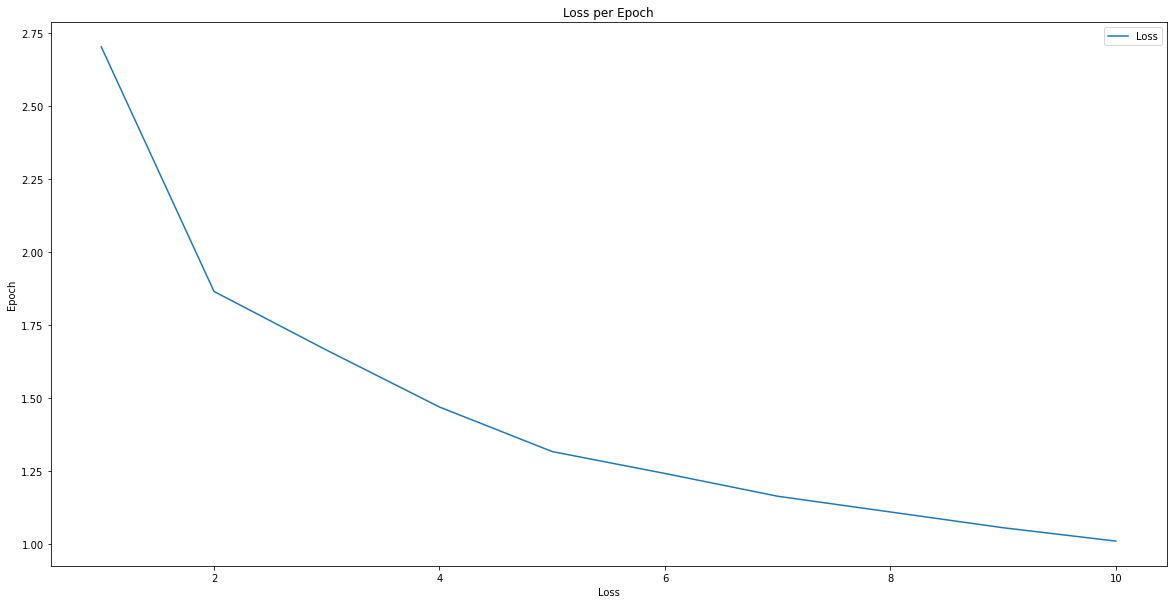

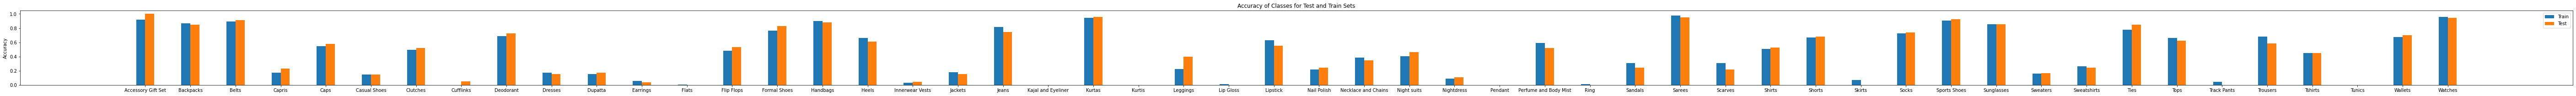

In [23]:
# Normalized 32-batch-size Dataset with Random Initial Weights, Optimum Learning Rate, and No Momentum and Regularization (10 epochs)
model = Model(len(classes))
model = model.to(device)
learning_rate = bestLR
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
print('Results of Normalized 32-batch-size Dataset with Optimum Learning Rate and No Momentum and Regularization: (10 epochs)')
epochs, avgLosses = fit(model, train_loader_norm32, device, criterion, optimizer)
train_acc, train_class_accs = model_accuracy(model, train_loader_norm32)
test_acc, test_class_accs = model_accuracy(model, test_loader_norm32)
print('Train Set Accuracy: {}%'.format(train_acc))
print('Test Set Accuracy: {}%'.format(test_acc))
plotLoss(epochs, avgLosses)
plotAccs(train_class_accs, test_class_accs, classes)

Results of Normalized 128-batch-size Dataset with Optimum Learning Rate and No Momentum and Regularization: (10 epochs)
epoch 1, train_loss: 3.269, time elapsed: 43.501856 seconds
epoch 2, train_loss: 2.575, time elapsed: 43.356721 seconds
epoch 3, train_loss: 2.186, time elapsed: 42.109569 seconds
epoch 4, train_loss: 1.973, time elapsed: 42.730046 seconds
epoch 5, train_loss: 1.776, time elapsed: 42.514918 seconds
epoch 6, train_loss: 1.665, time elapsed: 42.065461 seconds
epoch 7, train_loss: 1.538, time elapsed: 41.467625 seconds
epoch 8, train_loss: 1.480, time elapsed: 42.259673 seconds
epoch 9, train_loss: 1.406, time elapsed: 43.125267 seconds
epoch 10, train_loss: 1.335, time elapsed: 41.797324 seconds
total training time: 7.082 minutes
Train Set Accuracy: 57.13278969092923%
Test Set Accuracy: 57.38255033557047%


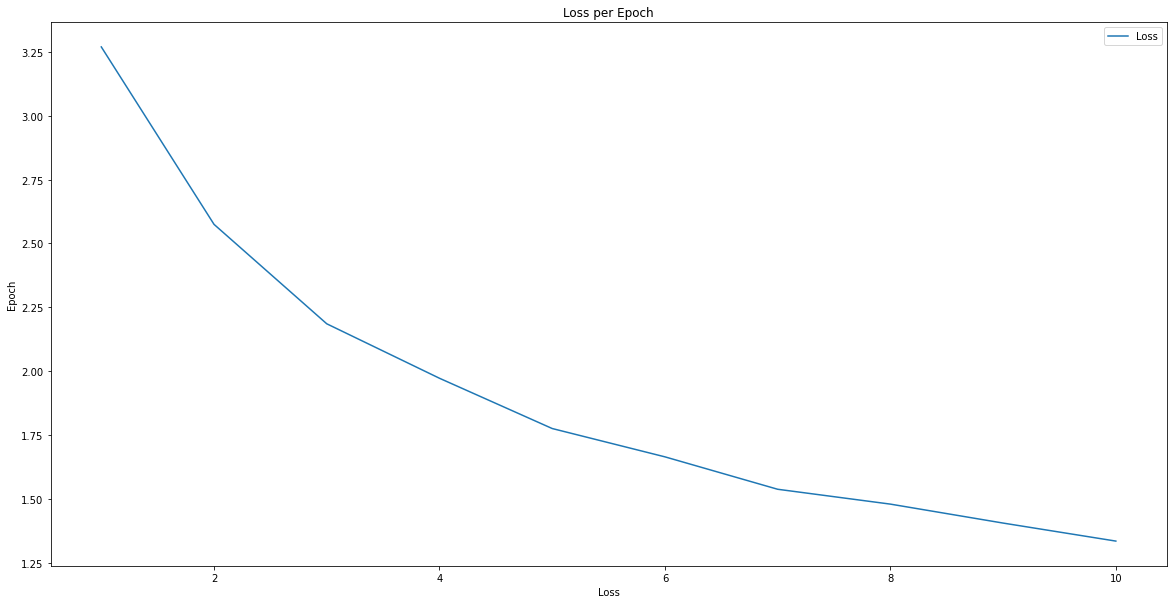

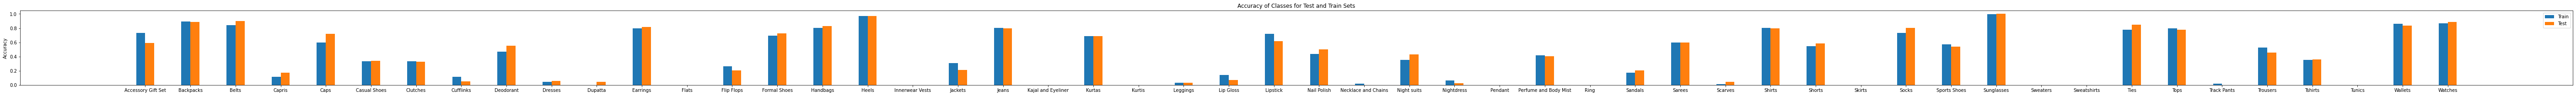

In [24]:
# Normalized 128-batch-size Dataset with Random Initial Weights, Optimum Learning Rate, and No Momentum and Regularization (10 epochs)
model = Model(len(classes))
model = model.to(device)
learning_rate = bestLR
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
print('Results of Normalized 128-batch-size Dataset with Optimum Learning Rate and No Momentum and Regularization: (10 epochs)')
epochs, avgLosses = fit(model, train_loader_norm128, device, criterion, optimizer)
train_acc, train_class_accs = model_accuracy(model, train_loader_norm128)
test_acc, test_class_accs = model_accuracy(model, test_loader_norm128)
print('Train Set Accuracy: {}%'.format(train_acc))
print('Test Set Accuracy: {}%'.format(test_acc))
plotLoss(epochs, avgLosses)
plotAccs(train_class_accs, test_class_accs, classes)

Results of Normalized 64-batch-size Dataset with Optimum Learning Rate and Momentum = 0.98 and Regularization: (10 epochs)
epoch 1, train_loss: 3.476, time elapsed: 42.47008 seconds
epoch 2, train_loss: 3.460, time elapsed: 42.153062 seconds
epoch 3, train_loss: 3.460, time elapsed: 42.765997 seconds
epoch 4, train_loss: 3.461, time elapsed: 43.932554 seconds
epoch 5, train_loss: 3.460, time elapsed: 43.269911 seconds
epoch 6, train_loss: 3.461, time elapsed: 42.4011 seconds
epoch 7, train_loss: 3.460, time elapsed: 43.207618 seconds
epoch 8, train_loss: 3.462, time elapsed: 42.728074 seconds
epoch 9, train_loss: 3.463, time elapsed: 42.340011 seconds
epoch 10, train_loss: 3.463, time elapsed: 42.602085 seconds
total training time: 7.131 minutes
Train Set Accuracy: 9.48689553340716%
Test Set Accuracy: 9.48993288590604%


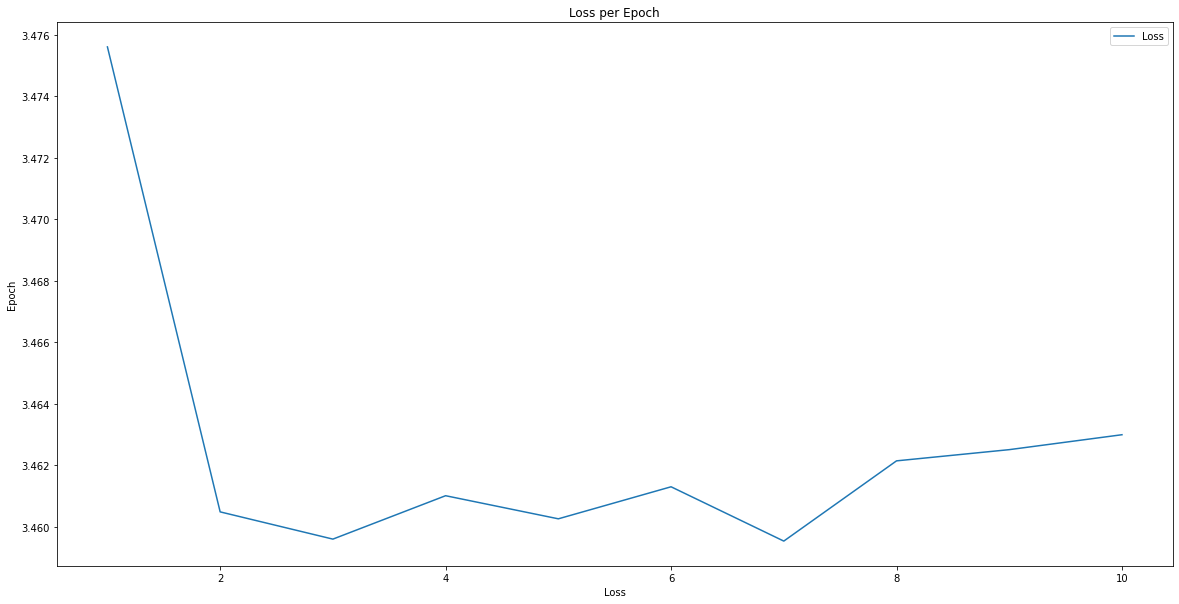

Results of Normalized 64-batch-size Dataset with Optimum Learning Rate and Momentum = 0.9 and Regularization: (10 epochs)
epoch 1, train_loss: 2.799, time elapsed: 42.476266 seconds
epoch 2, train_loss: 2.386, time elapsed: 42.28698 seconds
epoch 3, train_loss: 2.211, time elapsed: 42.534195 seconds
epoch 4, train_loss: 2.240, time elapsed: 42.343127 seconds
epoch 5, train_loss: 2.565, time elapsed: 42.374461 seconds


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f95439687f0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f95439687f0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/l

epoch 6, train_loss: 3.351, time elapsed: 44.690769 seconds


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f95439687f0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f95439687f0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f95439687f0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f95439687f0>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f95439687f0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter ob

epoch 7, train_loss: 3.456, time elapsed: 44.434339 seconds


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f95439687f0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f95439687f0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f95439687f0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f95439687f0>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
Exception ignored in: <bound method _MultiProcessingDataLoaderIt

epoch 8, train_loss: 3.453, time elapsed: 45.107953 seconds
epoch 9, train_loss: 3.452, time elapsed: 42.296072 seconds
epoch 10, train_loss: 3.452, time elapsed: 42.752074 seconds
total training time: 7.188 minutes
Train Set Accuracy: 9.48689553340716%
Test Set Accuracy: 9.48993288590604%


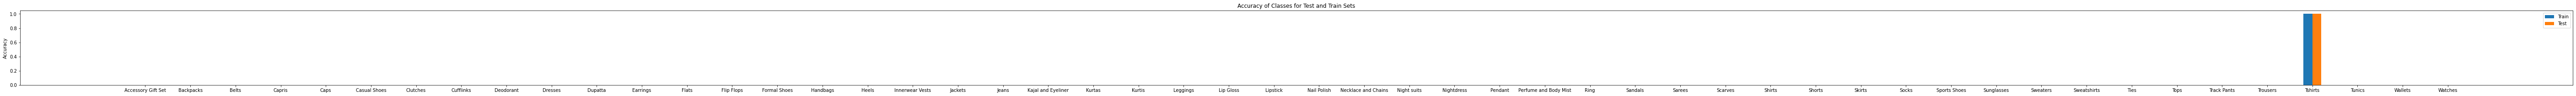

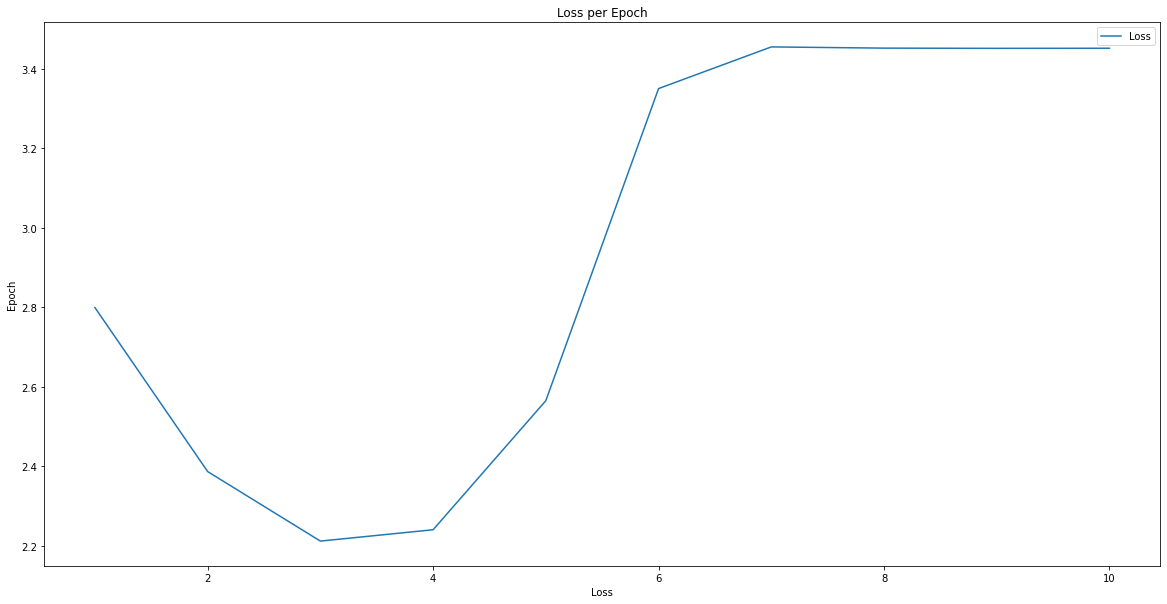

Results of Normalized 64-batch-size Dataset with Optimum Learning Rate and Momentum = 0.5 and Regularization: (10 epochs)
epoch 1, train_loss: 2.834, time elapsed: 42.756781 seconds
epoch 2, train_loss: 1.978, time elapsed: 42.351695 seconds
epoch 3, train_loss: 1.636, time elapsed: 43.19635 seconds
epoch 4, train_loss: 1.454, time elapsed: 44.093514 seconds
epoch 5, train_loss: 1.332, time elapsed: 43.215873 seconds
epoch 6, train_loss: 1.245, time elapsed: 42.847454 seconds
epoch 7, train_loss: 1.170, time elapsed: 43.369378 seconds
epoch 8, train_loss: 1.117, time elapsed: 43.54318 seconds
epoch 9, train_loss: 1.070, time elapsed: 42.976263 seconds
epoch 10, train_loss: 1.012, time elapsed: 43.169187 seconds
total training time: 7.192 minutes
Train Set Accuracy: 64.01221517500588%
Test Set Accuracy: 63.624161073825505%


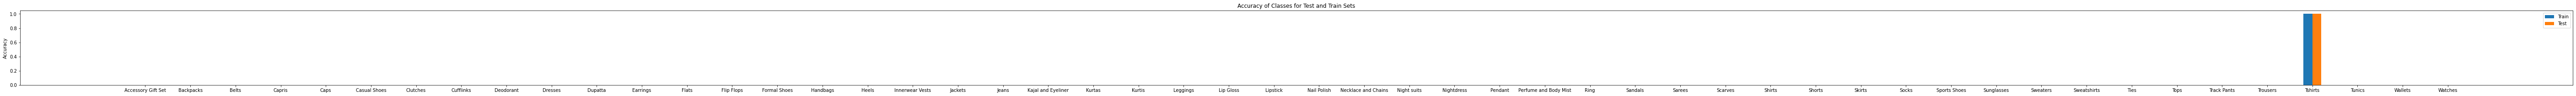

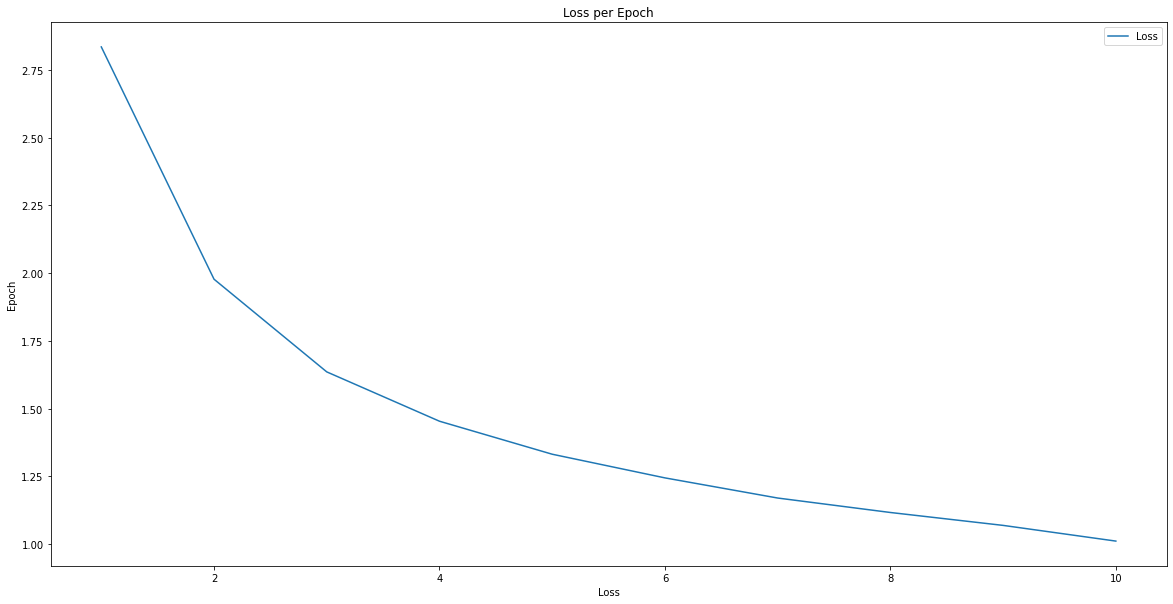

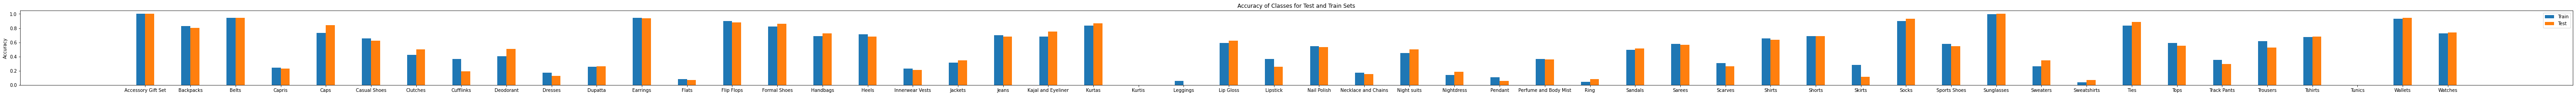

In [26]:
# Optimizing Momentum for Normalized 64-batch-size Dataset with Random Initial Weights, and No Regularization (10 epochs)
print('Results of Normalized 64-batch-size Dataset with Optimum Learning Rate and Momentum =',0.98,'and Regularization: (10 epochs)')
model = Model(len(classes))
model = model.to(device)
learning_rate = bestLR
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.98)
epochs, avgLosses = fit(model, train_loader_norm64, device, criterion, optimizer)
train_acc98, train_class_accs = model_accuracy(model, train_loader_norm64)
test_acc98, test_class_accs = model_accuracy(model, test_loader_norm64)
print('Train Set Accuracy: {}%'.format(train_acc98))
print('Test Set Accuracy: {}%'.format(test_acc98))
plotLoss(epochs, avgLosses)
plotAccs(train_class_accs, test_class_accs, classes)

print('Results of Normalized 64-batch-size Dataset with Optimum Learning Rate and Momentum =',0.9,'and Regularization: (10 epochs)')
model = Model(len(classes))
model = model.to(device)
learning_rate = bestLR
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9)
epochs, avgLosses = fit(model, train_loader_norm64, device, criterion, optimizer)
train_acc9, train_class_accs = model_accuracy(model, train_loader_norm64)
test_acc9, test_class_accs = model_accuracy(model, test_loader_norm64)
print('Train Set Accuracy: {}%'.format(train_acc9))
print('Test Set Accuracy: {}%'.format(test_acc9))
plotLoss(epochs, avgLosses)
plotAccs(train_class_accs, test_class_accs, classes)

print('Results of Normalized 64-batch-size Dataset with Optimum Learning Rate and Momentum =',0.5,'and Regularization: (10 epochs)')
model = Model(len(classes))
model = model.to(device)
learning_rate = bestLR
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.5)
epochs, avgLosses = fit(model, train_loader_norm64, device, criterion, optimizer)
train_acc5, train_class_accs = model_accuracy(model, train_loader_norm64)
test_acc5, test_class_accs = model_accuracy(model, test_loader_norm64)
print('Train Set Accuracy: {}%'.format(train_acc5))
print('Test Set Accuracy: {}%'.format(test_acc5))
plotLoss(epochs, avgLosses)
plotAccs(train_class_accs, test_class_accs, classes)

In [29]:
optMom = -1
if test_acc98 >= test_acc9 and test_acc9 >= test_acc5:
  optMom = 0.98
elif test_acc9 >= test_acc98 and test_acc9 >= test_acc5:
  optMom = 0.9
else:
  optMom = 0.5

Results of Normalized 64-batch-size Dataset with Optimum Learning Rate and Momentum and No Regularization: (20 epochs)
epoch 1, train_loss: 2.884, time elapsed: 42.976385 seconds
epoch 2, train_loss: 2.057, time elapsed: 42.539699 seconds
epoch 3, train_loss: 1.668, time elapsed: 43.15995 seconds
epoch 4, train_loss: 1.498, time elapsed: 42.961849 seconds
epoch 5, train_loss: 1.356, time elapsed: 42.856779 seconds
epoch 6, train_loss: 1.297, time elapsed: 44.128395 seconds
epoch 7, train_loss: 1.185, time elapsed: 43.034449 seconds
epoch 8, train_loss: 1.132, time elapsed: 43.313376 seconds
epoch 9, train_loss: 1.077, time elapsed: 43.021871 seconds
epoch 10, train_loss: 1.033, time elapsed: 42.997202 seconds
epoch 11, train_loss: 1.003, time elapsed: 43.166536 seconds
epoch 12, train_loss: 0.961, time elapsed: 43.471871 seconds
epoch 13, train_loss: 0.932, time elapsed: 44.51227 seconds
epoch 14, train_loss: 0.897, time elapsed: 42.709138 seconds
epoch 15, train_loss: 0.880, time elap

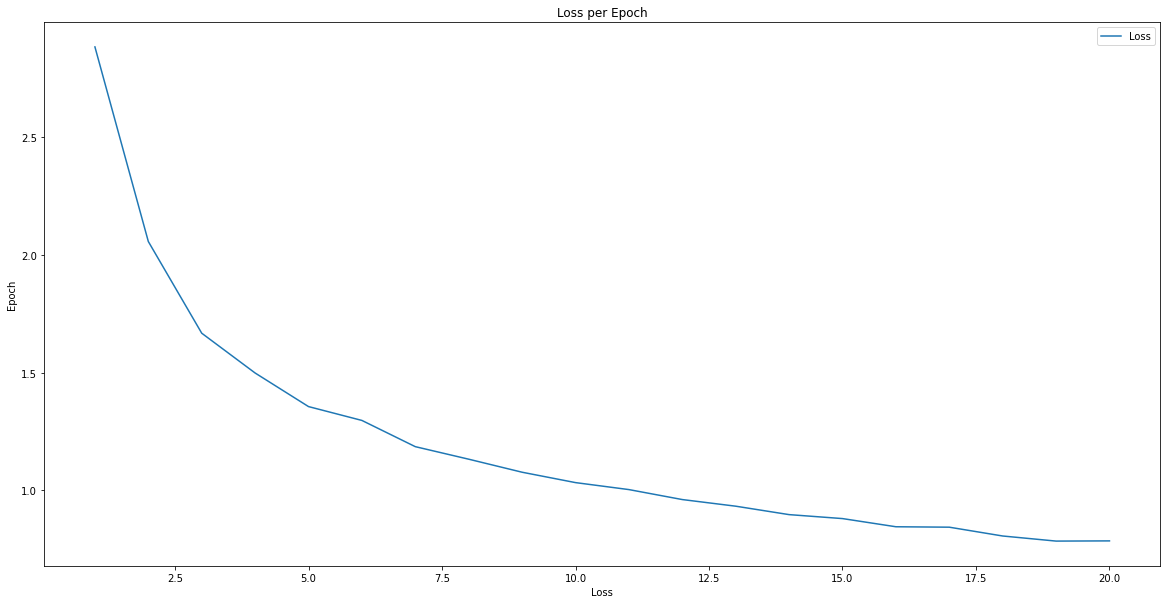

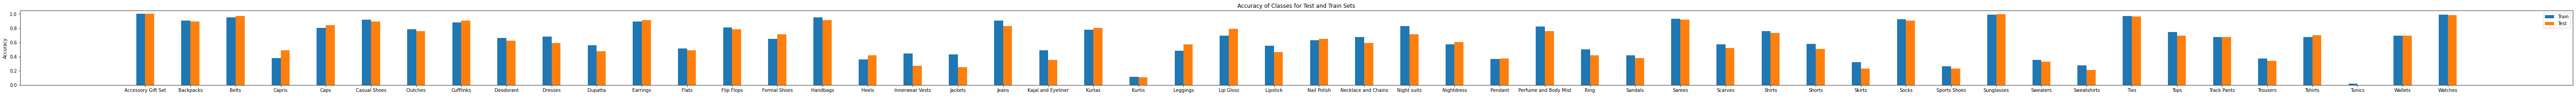

In [30]:
# Normalized 64-batch-size Dataset with Random Initial Weights, Optimum Learning Rate and Momentum, and No Regularization (20 epochs)
print('Results of Normalized 64-batch-size Dataset with Optimum Learning Rate and Momentum and No Regularization: (20 epochs)')
model = Model(len(classes))
model = model.to(device)
learning_rate = bestLR
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = optMom)
epochs, avgLosses = fit(model, train_loader_norm64, device, criterion, optimizer, 20)
train_acc, train_class_accs = model_accuracy(model, train_loader_norm64)
test_acc, test_class_accs = model_accuracy(model, test_loader_norm64)
print('Train Set Accuracy: {}%'.format(train_acc))
print('Test Set Accuracy: {}%'.format(test_acc))
plotLoss(epochs, avgLosses)
plotAccs(train_class_accs, test_class_accs, classes)

Results of Normalized 64-batch-size Dataset with Optimum Learning Rate and Momentum and No Regularization: (20 epochs)
Activation Function Changed to Tanh


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch 1, train_loss: 2.328, time elapsed: 43.370078 seconds
epoch 2, train_loss: 1.538, time elapsed: 43.116411 seconds
epoch 3, train_loss: 1.321, time elapsed: 43.859728 seconds
epoch 4, train_loss: 1.193, time elapsed: 44.440046 seconds
epoch 5, train_loss: 1.119, time elapsed: 43.788127 seconds
epoch 6, train_loss: 1.056, time elapsed: 44.651617 seconds
epoch 7, train_loss: 0.991, time elapsed: 43.936072 seconds
epoch 8, train_loss: 0.955, time elapsed: 44.057333 seconds
epoch 9, train_loss: 0.926, time elapsed: 43.732121 seconds
epoch 10, train_loss: 0.884, time elapsed: 43.69618 seconds
total training time: 7.311 minutes
Train Set Accuracy: 70.7607637840196%
Test Set Accuracy: 69.85234899328859%


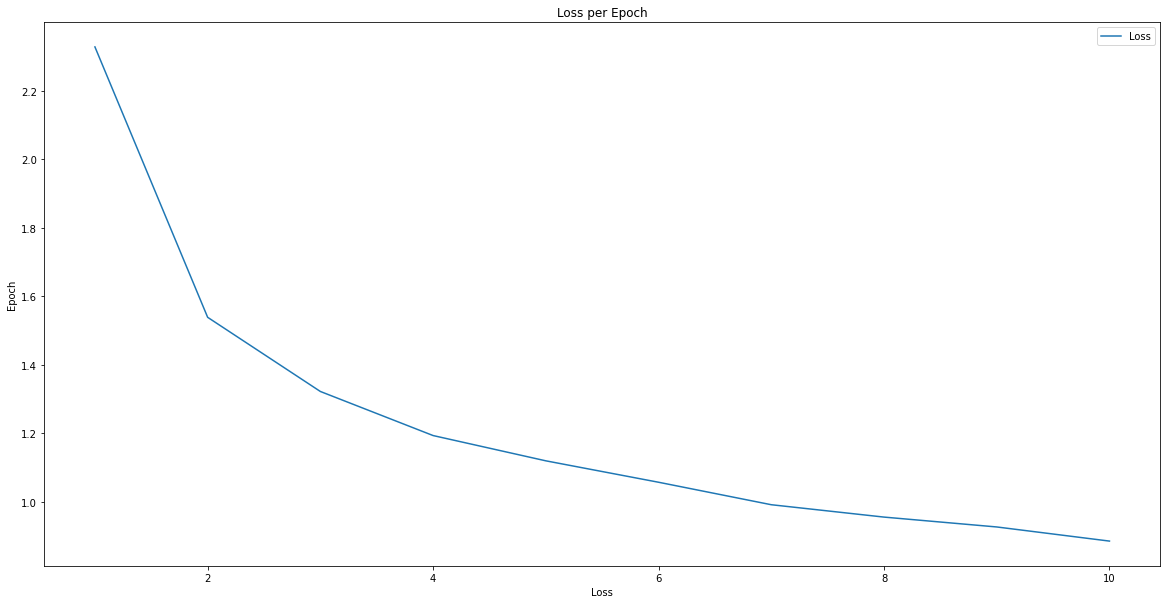

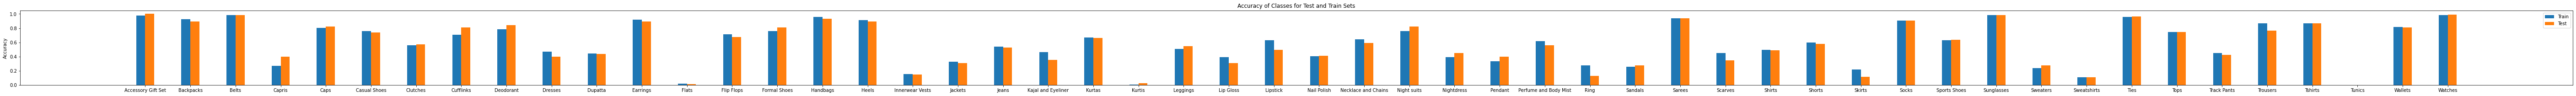

In [31]:
# Normalized 64-batch-size Dataset with Random Initial Weights, Optimum Learning Rate and Momentum, and No Regularization (20 epochs)
# Activation Function Chanege to Tanh
print('Results of Normalized 64-batch-size Dataset with Optimum Learning Rate and Momentum and No Regularization: (20 epochs)')
print('Activation Function Changed to Tanh')
model = Model(len(classes), F.tanh)
model = model.to(device)
learning_rate = bestLR
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = optMom)
epochs, avgLosses = fit(model, train_loader_norm64, device, criterion, optimizer, 10)
train_acc, train_class_accs = model_accuracy(model, train_loader_norm64)
test_acc, test_class_accs = model_accuracy(model, test_loader_norm64)
print('Train Set Accuracy: {}%'.format(train_acc))
print('Test Set Accuracy: {}%'.format(test_acc))
plotLoss(epochs, avgLosses)
plotAccs(train_class_accs, test_class_accs, classes)

Results of Normalized 64-batch-size Dataset with Optimum Learning Rate and Momentum and No Regularization: (20 epochs)
Activation Function Changed to Leaky Relu
epoch 1, train_loss: 2.714, time elapsed: 43.984658 seconds
epoch 2, train_loss: 2.055, time elapsed: 44.98927 seconds
epoch 3, train_loss: 1.701, time elapsed: 43.991094 seconds
epoch 4, train_loss: 1.475, time elapsed: 43.651848 seconds
epoch 5, train_loss: 1.348, time elapsed: 44.098552 seconds
epoch 6, train_loss: 1.246, time elapsed: 44.204018 seconds
epoch 7, train_loss: 1.170, time elapsed: 44.308262 seconds
epoch 8, train_loss: 1.110, time elapsed: 44.451722 seconds
epoch 9, train_loss: 1.056, time elapsed: 45.196704 seconds
epoch 10, train_loss: 1.019, time elapsed: 44.244886 seconds
total training time: 7.385 minutes
Train Set Accuracy: 61.679922145038425%
Test Set Accuracy: 61.81208053691275%


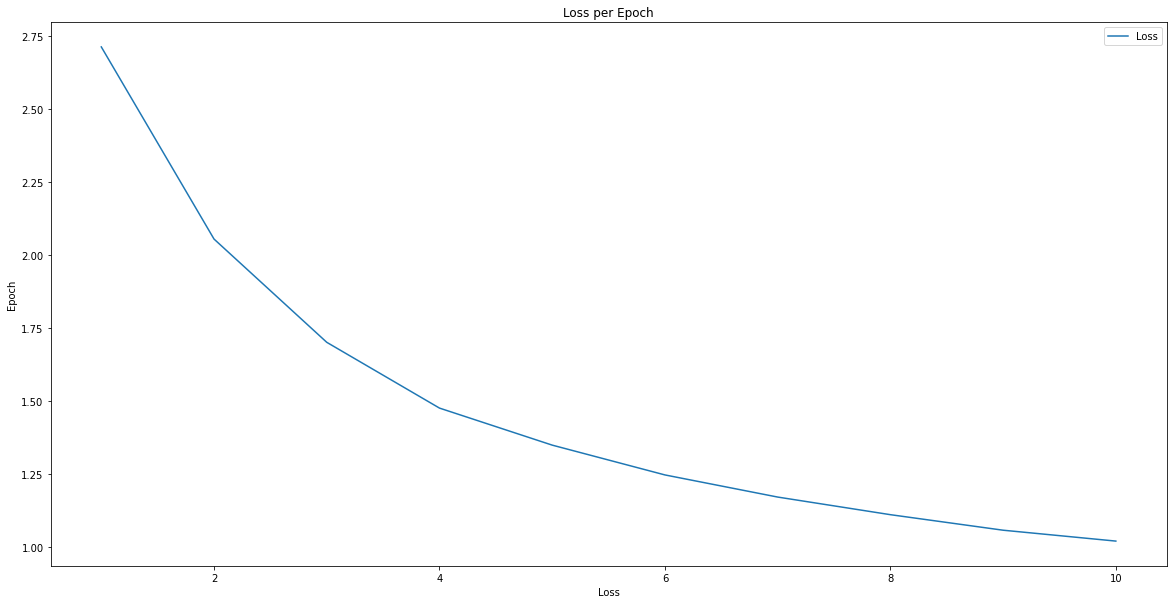

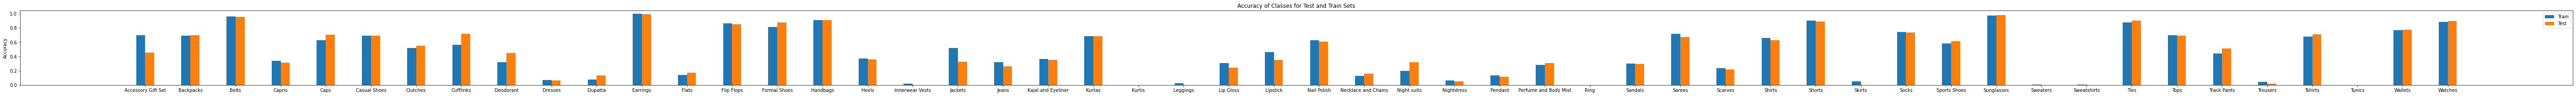

In [32]:
# Normalized 64-batch-size Dataset with Random Initial Weights, Optimum Learning Rate and Momentum, and No Regularization (20 epochs)
# Activation Function Chanege to Leaky Relu
print('Results of Normalized 64-batch-size Dataset with Optimum Learning Rate and Momentum and No Regularization: (20 epochs)')
print('Activation Function Changed to Leaky Relu')
model = Model(len(classes), F.leaky_relu)
model = model.to(device)
learning_rate = bestLR
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = optMom)
epochs, avgLosses = fit(model, train_loader_norm64, device, criterion, optimizer, 10)
train_acc, train_class_accs = model_accuracy(model, train_loader_norm64)
test_acc, test_class_accs = model_accuracy(model, test_loader_norm64)
print('Train Set Accuracy: {}%'.format(train_acc))
print('Test Set Accuracy: {}%'.format(test_acc))
plotLoss(epochs, avgLosses)
plotAccs(train_class_accs, test_class_accs, classes)

Results of Normalized 64-batch-size Dataset with Optimum Learning Rate and Momentum and No Regularization: (20 epochs)
0.1 Weight Decay Added
epoch 1, train_loss: 3.465, time elapsed: 43.848509 seconds
epoch 2, train_loss: 3.399, time elapsed: 43.513466 seconds
epoch 3, train_loss: 3.396, time elapsed: 43.876714 seconds
epoch 4, train_loss: 3.400, time elapsed: 44.662413 seconds
epoch 5, train_loss: 3.395, time elapsed: 44.830779 seconds
epoch 6, train_loss: 3.395, time elapsed: 44.030909 seconds
epoch 7, train_loss: 3.400, time elapsed: 43.73297 seconds
epoch 8, train_loss: 3.396, time elapsed: 44.16543 seconds
epoch 9, train_loss: 3.415, time elapsed: 44.508762 seconds
epoch 10, train_loss: 3.406, time elapsed: 44.016927 seconds
total training time: 7.353 minutes
Train Set Accuracy: 9.48689553340716%
Test Set Accuracy: 9.48993288590604%


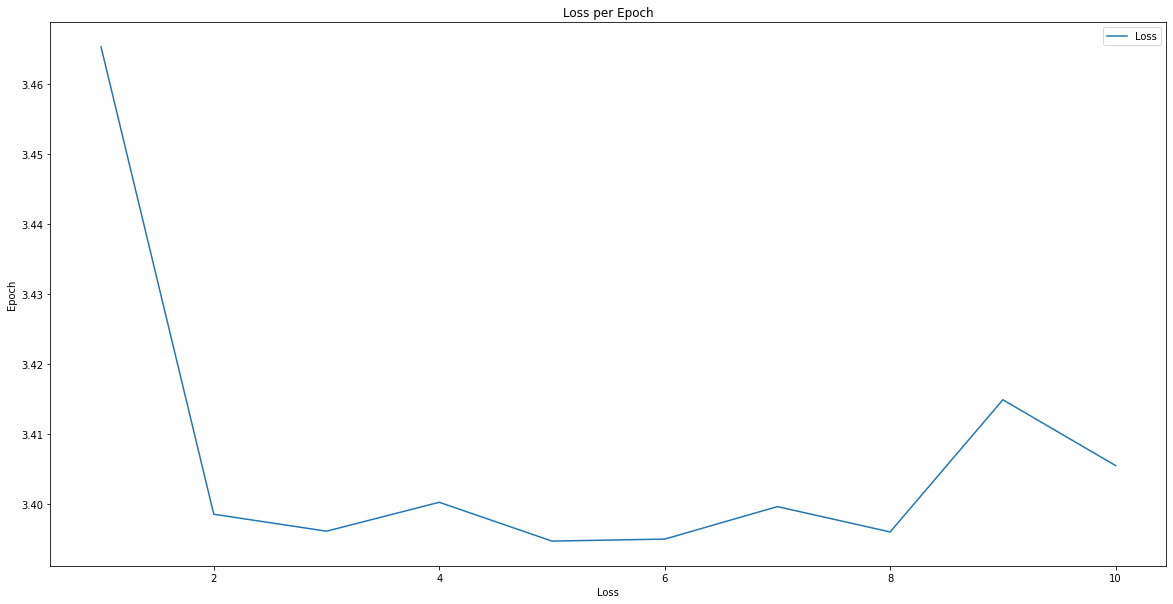

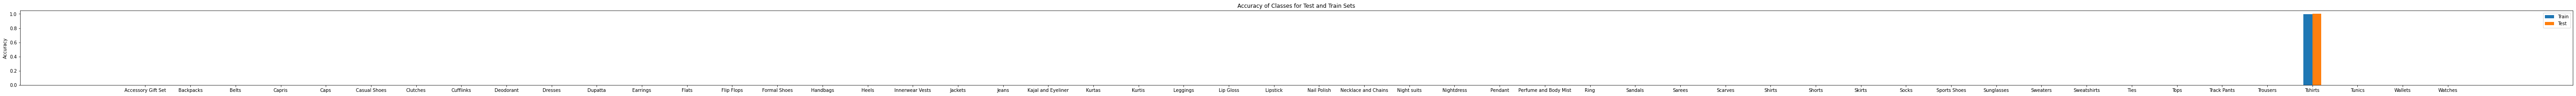

In [33]:
# Normalized 64-batch-size Dataset with Random Initial Weights, Optimum Learning Rate and Momentum, and No Regularization (20 epochs)
# 0.1 Weight Decay Added
print('Results of Normalized 64-batch-size Dataset with Optimum Learning Rate and Momentum and No Regularization: (20 epochs)')
print('0.1 Weight Decay Added')
model = Model(len(classes))
model = model.to(device)
learning_rate = bestLR
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = optMom, weight_decay=0.1)
epochs, avgLosses = fit(model, train_loader_norm64, device, criterion, optimizer, 10)
train_acc, train_class_accs = model_accuracy(model, train_loader_norm64)
test_acc, test_class_accs = model_accuracy(model, test_loader_norm64)
print('Train Set Accuracy: {}%'.format(train_acc))
print('Test Set Accuracy: {}%'.format(test_acc))
plotLoss(epochs, avgLosses)
plotAccs(train_class_accs, test_class_accs, classes)

Results of Normalized 64-batch-size Dataset with Optimum Learning Rate and Momentum and No Regularization: (20 epochs)
0.01 Weight Decay Added
epoch 1, train_loss: 2.931, time elapsed: 44.653927 seconds
epoch 2, train_loss: 2.392, time elapsed: 44.360363 seconds
epoch 3, train_loss: 2.112, time elapsed: 44.431618 seconds
epoch 4, train_loss: 2.062, time elapsed: 44.183966 seconds
epoch 5, train_loss: 2.045, time elapsed: 44.126929 seconds
epoch 6, train_loss: 2.001, time elapsed: 43.965218 seconds
epoch 7, train_loss: 1.980, time elapsed: 44.560881 seconds
epoch 8, train_loss: 2.168, time elapsed: 44.458695 seconds
epoch 9, train_loss: 2.164, time elapsed: 43.998938 seconds
epoch 10, train_loss: 1.994, time elapsed: 43.770712 seconds
total training time: 7.375 minutes
Train Set Accuracy: 32.35007886170677%
Test Set Accuracy: 32.91275167785235%


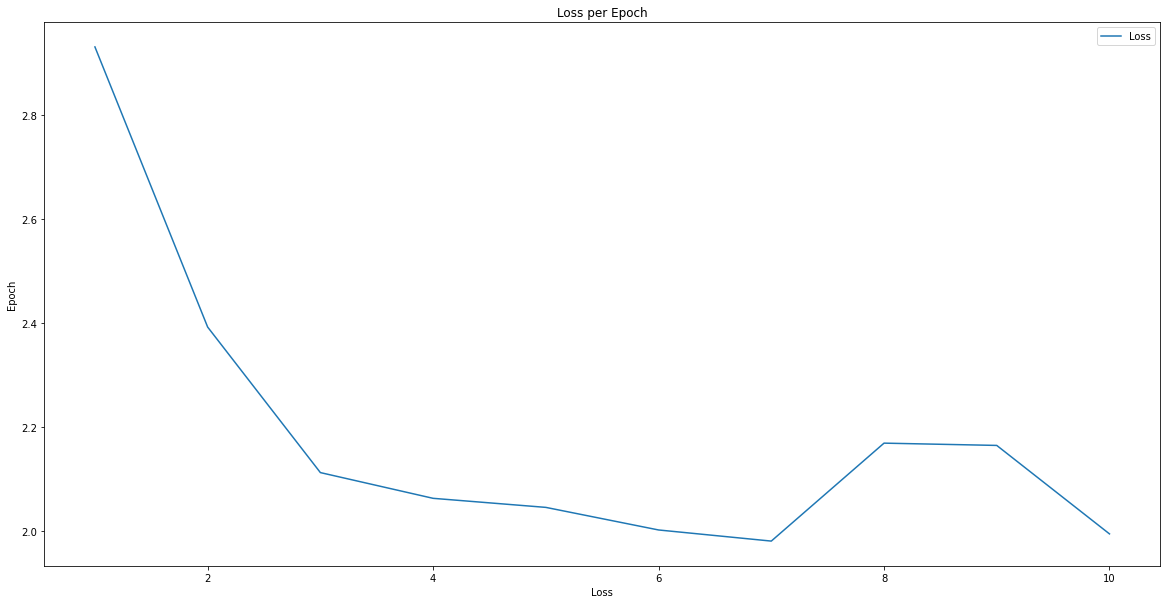

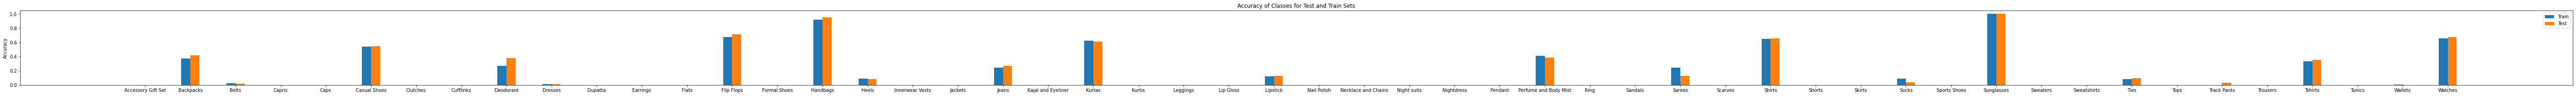

In [34]:
# Normalized 64-batch-size Dataset with Random Initial Weights, Optimum Learning Rate and Momentum, and No Regularization (20 epochs)
# 0.1 Weight Decay Added
print('Results of Normalized 64-batch-size Dataset with Optimum Learning Rate and Momentum and No Regularization: (20 epochs)')
print('0.01 Weight Decay Added')
model = Model(len(classes), F.leaky_relu)
model = model.to(device)
learning_rate = bestLR
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = optMom, weight_decay=0.01)
epochs, avgLosses = fit(model, train_loader_norm64, device, criterion, optimizer, 10)
train_acc, train_class_accs = model_accuracy(model, train_loader_norm64)
test_acc, test_class_accs = model_accuracy(model, test_loader_norm64)
print('Train Set Accuracy: {}%'.format(train_acc))
print('Test Set Accuracy: {}%'.format(test_acc))
plotLoss(epochs, avgLosses)
plotAccs(train_class_accs, test_class_accs, classes)